# Episode 40. Variational Autoencoder (VAE)

## Import Libraries

In [393]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Creating synthetic data

In [394]:
# Define the desired number of samples for each class
class_samples = [2000, 10000]  # Adjust these numbers as needed

# Calculate weights based on the desired number of samples
class_weights = [num_samples / sum(class_samples) for num_samples in class_samples]


# Generate a synthetic dataset with different numbers of samples for each class
X, y = make_classification(
    n_samples=sum(class_samples),
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_classes=2,
    weights=class_weights,
    random_state=42,
)


# Create a Pandas DataFrame with the generated data
columns = ["Feature_1", "Feature_2", "Feature_3", "Feature_4"]
synthetic_df = pd.DataFrame(data=X, columns=columns)

for column in synthetic_df:
    std = np.std(synthetic_df[column])
    mean = np.mean(synthetic_df[column])
    synthetic_df[column] = synthetic_df[column]-mean
    synthetic_df[column] = synthetic_df[column]/std

synthetic_df["target"] = y

# Display the first few rows of the synthetic dataset
synthetic_array =synthetic_df.values


X_train, X_test= train_test_split(synthetic_array, test_size=0.2, random_state=42)


## Load Data

## Rescale Data (value range 0-255 to range 0-1)

## Variational Autoencoder Network

### (1) Define Network Parameters

In [395]:
# defining the key parameters
batch_size = 32
original_dim = 5
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [396]:
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

### (2) Sampling Random Number

In [397]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### (3) Defining Encoder

In [398]:
encoder_inputs = Input(shape=(original_dim,), name="input")
x1 = Dense(50, activation="relu", name="h1")(encoder_inputs)
x2 = Dense(40, activation="relu", name="h2")(x1)
n_x3 = 30
x3 = Dense(n_x3, activation="relu", name="h3")(x2)

# Split x3 into two halves
half_size = n_x3 // 2
x3_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x3)
x3_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x3)

z_mean = Dense(latent_dim, name="z_mean")(x3_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x3_second_half)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var], )
# defining the encoder as a keras model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 5)]          0           []                               
                                                                                                  
 h1 (Dense)                     (None, 50)           300         ['input[0][0]']                  
                                                                                                  
 h2 (Dense)                     (None, 40)           2040        ['h1[0][0]']                     
                                                                                                  
 h3 (Dense)                     (None, 30)           1230        ['h2[0][0]']                     
                                                                                            

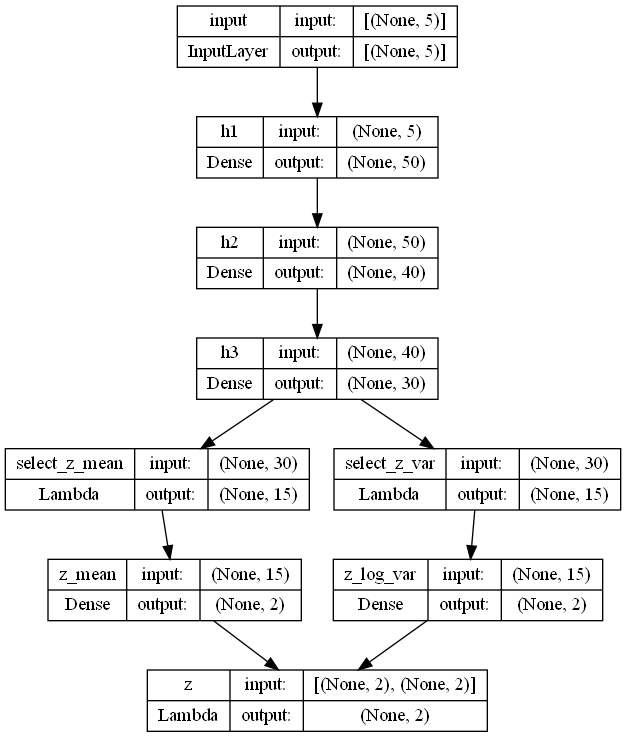

In [399]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

### (4) Define Decoder

In [400]:
# Decoder
latent_inputs = Input(shape=(latent_dim,))
x4 = Dense(30, activation="relu", name="h4")(latent_inputs)
x5 = Dense(40, activation="relu", name="h5")(x4)

n_x6 = 50

x6 = Dense(n_x6, activation="relu", name="h6")(x5)

# Split x6 into two parts (80% and 20%)
cont_decoder_input = Lambda(lambda x: x[:, :int(0.8 * n_x6)], name="select_x6_cont")(x6)
class_decoder_input = Lambda(lambda x: x[:, int(0.8 * n_x6):], name="select_x6_class")(x6)

cont_decoder_outputs = Dense(4, name="cont_decoder_output")(cont_decoder_input)
class_decoder_output = Dense(2, activation="sigmoid", name="classification_output")(class_decoder_input)
decoder = Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")

decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 h4 (Dense)                     (None, 30)           90          ['input_25[0][0]']               
                                                                                                  
 h5 (Dense)                     (None, 40)           1240        ['h4[0][0]']                     
                                                                                                  
 h6 (Dense)                     (None, 50)           2050        ['h5[0][0]']                     
                                                                                            

### (5) Define Variational Autoencoder (VAE)

In [401]:
decoder(encoder(X_train[0].reshape(1, -1))[2])

[<tf.Tensor 'decoder_67/cont_decoder_output/BiasAdd:0' shape=(1, 4) dtype=float32>,
 <tf.Tensor 'decoder_67/classification_output/Sigmoid:0' shape=(1, 2) dtype=float32>]

In [402]:
logits = decoder(encoder(X_train[0].reshape(1, -1))[2])[1]  # Assuming output of the classification decoder


In [403]:
data_class = X_train[:, 4:]

In [404]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(encoder_inputs)[2])
# link the input and the overall output
vae = Model(encoder_inputs, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 encoder (Functional)        [(None, 2),               3634      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        [(None, 4),               3566      
                              (None, 2)]                         
                                                                 
Total params: 7,200
Trainable params: 7,200
Non-trainable params: 0
_________________________________________________________________


In [405]:
decoder(encoder(X_train[0].reshape(1, -1))[2])[1]

<tf.Tensor 'decoder_70/classification_output/Sigmoid:0' shape=(1, 2) dtype=float32>

### (6) VAE Loss

In [406]:
# Defina VAE Loss Function
def vae_loss_custom(data: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    data_cont = data[:, :4] 
    data_class = data[:, 4:]
    print(data_class)
    cont_loss = original_dim/(4/5) * tf.keras.losses.mean_squared_error(data_cont, x_decoded_mean[0])
    class_loss =  original_dim/(1/5)*tf.keras.losses.binary_crossentropy(
                data_class, x_decoded_mean[1])
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(cont_loss + class_loss + kl_loss)
    return vae_loss

In [407]:
# Defina VAE Loss Function
def vae_loss(data: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    cont_loss = original_dim*(4/5) * tf.keras.losses.mean_squared_error(data[:, :4] , x_decoded_mean[0][0])
    class_loss = original_dim*(1/5) * tf.keras.losses.binary_crossentropy(data[:, 4:] , x_decoded_mean[0][1])
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(cont_loss + class_loss + kl_loss)
    return vae_loss

### (7) Compile VAE

In [408]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 encoder (Functional)        [(None, 2),               3634      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        [(None, 4),               3566      
                              (None, 2)]                         
                                                                 
Total params: 7,200
Trainable params: 7,200
Non-trainable params: 0
_________________________________________________________________


### (8) Train VAE

In [409]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights
)

cont_target_data = X_train[:, :4] 
class_target_data = X_train[:, 4:]
cont_val_data = X_test[:, :4] 
class_val_data = X_test[:, :4] 


# Fit the VAE model with early stopping
history = vae.fit(
    X_train, [X_train[:, :4], X_train[:, 4:]],
    epochs=epochs,
    batch_size=batch_size,
    #shuffle=True,
    #validation_data=(X_test, [cont_val_data, class_val_data]),
    verbose=1,
    #callbacks=[early_stopping]  # Include early stopping callback
).history

Train on 9600 samples
Epoch 1/50
9600/9600 [==============================] - 1s 154us/sample - loss: nan - decoder_loss: nan - decoder_1_loss: nan
Epoch 2/50
9600/9600 [==============================] - 1s 91us/sample - loss: nan - decoder_loss: nan - decoder_1_loss: nan
Epoch 3/50
9600/9600 [==============================] - 1s 86us/sample - loss: nan - decoder_loss: nan - decoder_1_loss: nan
Epoch 4/50
9600/9600 [==============================] - 1s 89us/sample - loss: nan - decoder_loss: nan - decoder_1_loss: nan
Epoch 5/50
9600/9600 [==============================] - 1s 106us/sample - loss: nan - decoder_loss: nan - decoder_1_loss: nan
Epoch 6/50
4160/9600 [============>.................] - ETA: 0s - loss: nan - decoder_loss: nan - decoder_1_loss: nan

KeyboardInterrupt: 

## Encoder Output: 2D Latent Space

In [ ]:
encoder_out = encoder.predict(X_test)[2]  # encoder output is [z_mean,z_log_var,z]

c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
encoder_out.shape
encoder_out[0:5,:]

array([[-0.38655916, -0.93473595],
       [-0.82556164,  0.46120363],
       [-0.30821455,  1.8387915 ],
       [-1.3636378 ,  0.34889373],
       [ 1.1665385 , -2.0794866 ]], dtype=float32)

ValueError: 'c' argument has 12000 elements, which is inconsistent with 'x' and 'y' with size 2400.

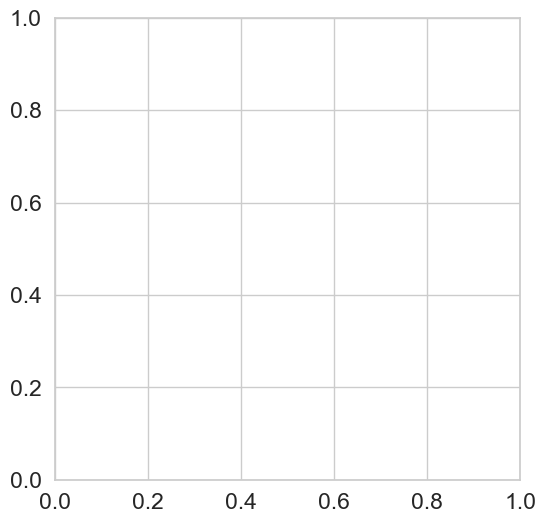

In [ ]:
# display a 2D plot of the digit classes in the latent space
plt.figure(figsize=(6, 6))
plt.scatter(encoder_out[:,0], encoder_out[:,1], c=y, cmap='viridis')
plt.colorbar()
plt.show()

## Reconstruction: test data

In [ ]:
vae_out = vae.predict(x_test)        # reconstruction

## Reconstruction Error: test data

In [ ]:
err2 = np.sum((x_test-vae_out)**2)/vae_out.shape[0]/vae_out.shape[1]
print('VAE reconstruction error: ' + str(round(err2,3)));

VAE reconstruction error: 0.042


## Plot Original (x) & Reconstructed (xhat) Image

In [ ]:
# select image
idx = 0
x_plot = x_test[idx,:]
xhat_plot = vae_out[idx,:]
# corresponding label
y_plot = y_test[idx]
# restore original value (from standardized 0-1 to original value 0-255)
x_plot = x_plot*255
xhat_plot = xhat_plot*255
# check label & x dimension
print(y_plot,x_plot.shape)

7 (784,)


In [ ]:
# reshape into 2D image data (784 to 28 x 28)
x_img = x_plot.reshape((28,28))
xhat_img = xhat_plot.reshape((28,28))

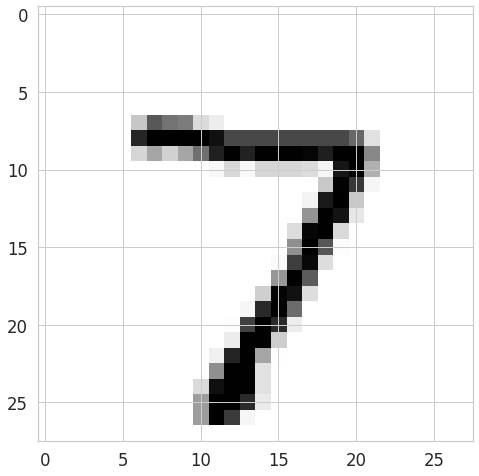

In [ ]:
# plot 2D image: Original
plt.imshow(x_img,cmap='Greys',interpolation='None')

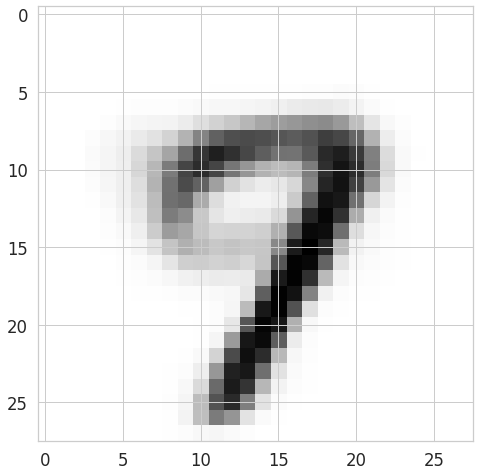

In [ ]:
# plot 2D image: Reconstructed
plt.imshow(xhat_img,cmap='Greys',interpolation='None')